In [80]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42



In [81]:
df = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_test.csv')

In [82]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [84]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/tmp/ipykernel_42/1259316306.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [85]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [87]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [88]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [89]:
df = df[['OriginalTweet','Sentiment']]

In [90]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [91]:
!pip install demoji
import demoji


# Clean emojis from text using the demoji library
def strip_emoji(text):
    return demoji.replace(text, '')

# Remove punctuations, links, mentions, and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()  # Remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # Remove non utf8/ascii characters
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))  # Remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))  # Remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

In [92]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


# Now, texts_new contains the cleaned tweets


In [93]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [94]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [95]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [96]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [97]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [98]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [99]:
df['text_len'] = text_len

In [100]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [101]:
df_test['text_len'] = text_len_test

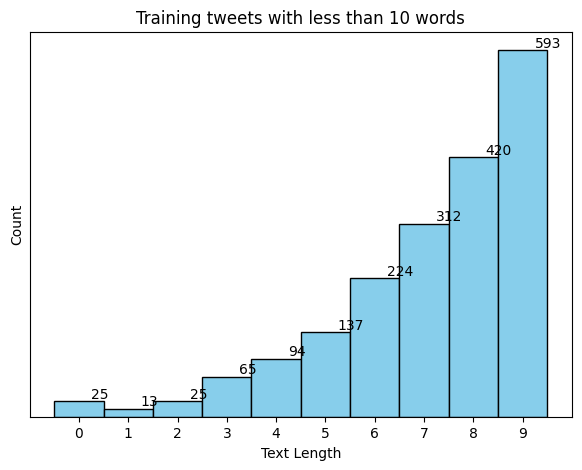

In [102]:
# Assuming df is your DataFrame
plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df = df[df['text_len'] < 10]

# Create a histogram using Matplotlib
counts, bins, _ = plt.hist(filtered_df['text_len'], bins=range(11), color='skyblue', edgecolor='black', align='left')

# Add labels and title
plt.title('Training tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(bins[:-1])  # Set x-axis ticks to bin edges
plt.yticks([])

# Add count labels on top of the bars
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.25, count, str(int(count)), va='bottom')

plt.show()

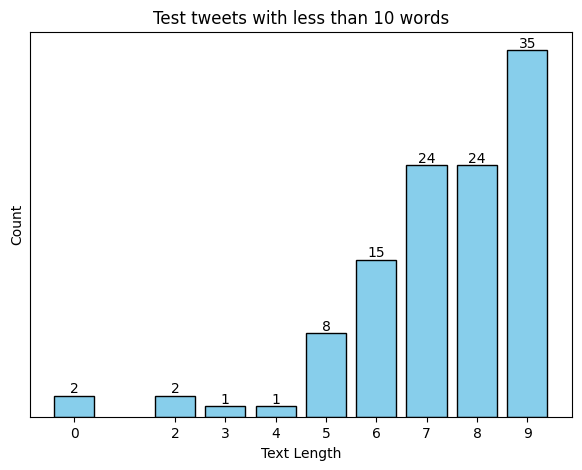

In [103]:
# Assuming df_test is your DataFrame
plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df_test = df_test[df_test['text_len'] < 10]

# Create a bar plot using Matplotlib
ax = plt.bar(filtered_df_test['text_len'].value_counts().sort_index().index,
             filtered_df_test['text_len'].value_counts().sort_index(), color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Test tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(filtered_df_test['text_len'].value_counts().sort_index().index)
plt.yticks([])

# Add count labels on top of the bars
for bar in ax:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.show()

In [104]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [105]:
df = df[df['text_len'] > 4]

In [106]:
df_test = df_test[df_test['text_len'] > 4]

In [107]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


In [108]:
from transformers import RemBertTokenizer

tokenizer = RemBertTokenizer.from_pretrained("google/rembert")

In [109]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [110]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 76


In [111]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [112]:
df['token_lens'] = token_lens

In [113]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,76
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,75
9238,Hi @Zomato I felt hungry loggd in ur app tryd ...,Extremely Positive,hi i felt hungry loggd in ur app tryd to add 4...,55,75
25975,#covid-19 #Isolation how on earth will you as...,Extremely Negative,covid19 isolation how on earth will you ask us...,57,73
30206,#LDA City Lahore Residential Files Prices Upda...,Neutral,lda city lahore residential files prices updat...,43,73
7351,SWEET BABY JESUS &amp; ALL HIS APOSTLES! I swe...,Extremely Positive,sweet baby jesus amp all his apostles i swear ...,56,72
21439,How can US oil rigs not drop hugely? Dallas Fe...,Extremely Positive,how can us oil rigs not drop hugely dallas fed...,52,72
11106,Which global recession? V or U or L or I? For ...,Negative,which global recession v or u or l or i for no...,64,72
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,72
40342,likeit Gallinago Gel cocaine has hiked in pric...,Neutral,likeit gallinago gel cocaine has hiked in pric...,54,71


In [114]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
35384,Safest Job in America is #Uninsured #SuperMark...,Extremely Positive,safest job in america is uninsured supermarket...,39,71
30443,NMDC has cut prices of lumps amp fines by 16 a...,Negative,nmdc has cut prices of lumps amp fines by 16 a...,58,71
13234,Govt of India issues Gazette of India order fi...,Extremely Positive,govt of india issues gazette of india order fi...,48,70
23019,4 arrested in Koboko (northern #Uganda) for hi...,Negative,4 arrested in koboko northern uganda for hikin...,50,70
40778,#Covid_19 2days Stay-at-home activities\r\r\nU...,Neutral,covid19 2days stayathome activities up 630am f...,37,70


In [115]:
df = df.sample(frac=1).reset_index(drop=True)

In [116]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [117]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 88


In [118]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b


In [119]:
df_test['token_lens'] = token_lens_test

In [120]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,88
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,73
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,71
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,71
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take her yo mama s...,53,71
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,69
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,69
1548,Working in a supermarket right now is like the...,Extremely Positive,working in a supermarket right now is like the...,49,69
1421,"THIS #Coronovirus IS SHOWING THE ""TRUE COLORS""...",Negative,this coronovirus is showing the true colors of...,50,68
671,"Please ppl, I just want to do my normal evenin...",Positive,please ppl i just want to do my normal evening...,51,68


In [121]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,69
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,69
1548,Working in a supermarket right now is like the...,Extremely Positive,working in a supermarket right now is like the...,49,69


In [122]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [123]:
df['Sentiment'].value_counts()

Sentiment
Positive              11382
Negative               9888
Neutral                7564
Extremely Positive     6614
Extremely Negative     5475
Name: count, dtype: int64

In [124]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [125]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [126]:
df['Sentiment'].value_counts()

Sentiment
2    17996
0    15363
1     7564
Name: count, dtype: int64

In [127]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [128]:
train_os['Sentiment'].value_counts()

Sentiment
1    17996
0    17996
2    17996
Name: count, dtype: int64

In [129]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [131]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [132]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [133]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [134]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48589
VALIDATION DATA: 5399
TESTING DATA: 3787


In [135]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [136]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [137]:
nb_clf = MultinomialNB()

In [138]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [139]:
nb_pred = nb_clf.predict(X_test_tf)

In [140]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.71      0.78      0.74      1628
     Neutral       0.60      0.45      0.51       615
    Positive       0.73      0.73      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787



In [141]:
MAX_LEN=128

In [142]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [143]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [144]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

71

In [145]:
MAX_LEN=80

In [146]:
def tokenize_rembert(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [147]:
train_input_ids, train_attention_masks = tokenize_rembert(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_rembert(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_rembert(X_test, MAX_LEN)

In [148]:
def create_model(deberta_model, max_len=MAX_LEN):
    # Freeze the DeBERTa model
    rembert_model.trainable = False

    opt = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = rembert_model([input_ids,attention_masks])
    output = tf.keras.layers.GlobalAveragePooling1D()(output[0])  # Add this line
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=[accuracy])
    return model

In [149]:
from transformers import TFRemBertModel

rembert_model = TFRemBertModel.from_pretrained("google/rembert")

All model checkpoint layers were used when initializing TFRemBertModel.

All the layers of TFRemBertModel were initialized from the model checkpoint at google/rembert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRemBertModel for predictions without further training.


In [150]:
model = create_model(rembert_model, MAX_LEN)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 tf_rem_bert_model_2 (TFRem  TFBaseModelOutputWithPooli   5759203   ['input_5[0][0]',             
 BertModel)                  ngAndCrossAttentions(last_   84         'input_6[0][0]']             
                             hidden_state=(None, 80, 11                                           
                             52),                                                           

In [151]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model_checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.001
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30, callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/4
1620/1620 [==============================] - ETA: 0s - loss: 1.0250 - categorical_accuracy: 0.4792

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1620/1620 [==============================] - 1536s 927ms/step - loss: 1.0250 - categorical_accuracy: 0.4792 - val_loss: 0.9912 - val_categorical_accuracy: 0.5184 - lr: 5.0000e-05
Epoch 2/4
1620/1620 [==============================] - 1490s 920ms/step - loss: 0.9758 - categorical_accuracy: 0.5330 - val_loss: 0.9617 - val_categorical_accuracy: 0.5451 - lr: 5.0000e-05
Epoch 3/4
1620/1620 [==============================] - 1487s 918ms/step - loss: 0.9531 - categorical_accuracy: 0.5498 - val_loss: 0.9456 - val_categorical_accuracy: 0.5583 - lr: 5.0000e-05
Epoch 4/4
1620/1620 [==============================] - 1487s 918ms/step - loss: 0.9384 - categorical_accuracy: 0.5593 - val_loss: 0.9344 - val_categorical_accuracy: 0.5660 - lr: 5.0000e-05


In [152]:
result_rembert= model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 111s 870ms/step


In [153]:
y_pred_rembert =  np.zeros_like(result_rembert)
y_pred_rembert[np.arange(len(y_pred_rembert)), result_rembert.argmax(1)] = 1

In [154]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import classification_report

# Assuming y_pred_megatronbert is the prediction from the MegatronBERT model
# Calculate MSE
mse = mean_squared_error(y_test,y_pred_rembert)

# Calculate RMSE
rmse = sqrt(mse)

# Print classification report, MSE and RMSE
print('\tMean Squared Error: ', mse)
print('\tRoot Mean Squared Error: ', rmse)
print('\n')

# Calculate accuracy
accuracy = accuracy_score(y_test,y_pred_rembert)

# Print classification report and accuracy
print('\tClassification Report for RemBERT:\n\n', classification_report(y_test,y_pred_rembert, target_names=['Negative', 'Neutral', 'Positive']))
print('\tAccuracy: ', accuracy)

	Mean Squared Error:  0.2996215121908283
	Root Mean Squared Error:  0.5473769379420622


	Classification Report for RemBERT:

               precision    recall  f1-score   support

    Negative       0.60      0.60      0.60      1628
     Neutral       0.38      0.60      0.47       615
    Positive       0.62      0.47      0.54      1544

   micro avg       0.55      0.55      0.55      3787
   macro avg       0.53      0.56      0.54      3787
weighted avg       0.57      0.55      0.55      3787
 samples avg       0.55      0.55      0.55      3787

	Accuracy:  0.5505677317137576
